In [2]:
import numpy as np
import pandas as pd 
import ast
import os
import random
import shutil
import cv2
from matplotlib import pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
filePath = "/kaggle/input/signverod"

In [5]:
train = pd.read_csv(filePath + '/train.csv')
test = pd.read_csv(filePath + '/test.csv')
mapping = pd.read_csv(filePath + '/image_ids.csv')

In [6]:
print(train.columns,"\t",train.shape)
print(test.columns,"\t",test.shape)
print(mapping.columns,"\t",mapping.shape)

Index(['area', 'bbox', 'category_id', 'id', 'image_id'], dtype='object') 	 (7549, 5)
Index(['area', 'bbox', 'category_id', 'id', 'image_id'], dtype='object') 	 (1666, 5)
Index(['height', 'width', 'id', 'file_name'], dtype='object') 	 (2765, 4)


There is some error in the 

In [7]:
mapping.loc[mapping.index > 2132, 'id'] += 2133

In [8]:
train.loc[train.index > 4309, 'image_id'] += 2133
train.loc[train.index > 4309, 'id'] += 4737

In [9]:
test.loc[test.index > 809, 'image_id'] += 2133
test.loc[test.index > 809, 'id'] += 4737

In [10]:
data = pd.concat([train, test]).drop_duplicates().sort_values(['id'])

In [11]:
data_merged = pd.merge(data, mapping, left_on='image_id', right_on='id', how='left')
data_merged = data_merged.drop(columns=['id_y'])

In [12]:
data_merged['category_id'] = data_merged['category_id'] - 1

data_merged.head()

,area,bbox,category_id,id_x,image_id,height,width,file_name
0,0.007,"[0.1444945139800141, 0.8143371482168966, 0.284...",0,1,1,3300.0,2560.0,nist_r0392_01.png
1,0.011,"[0.19762310567116137, 0.869482544646866, 0.354...",0,2,1,3300.0,2560.0,nist_r0392_01.png
2,0.007,"[0.13856792273017163, 0.8392342753794001, 0.23...",0,3,1,3300.0,2560.0,nist_r0392_01.png
3,0.009,"[0.14669516046674358, 0.8172596266496202, 0.33...",0,4,2,3300.0,2560.0,nist_r0647_01.png
4,0.010,"[0.1830540707236842, 0.8483832465277777, 0.293...",0,5,2,3300.0,2560.0,nist_r0647_01.png


In [ ]:
def convert_to_yolo_format(row):
    # Image dimensions
    img_width = row['width']
    img_height = row['height']
    bbox = ast.literal_eval(row['bbox'])
    a, b, c, d = map(float, bbox)
    xmin = int(a * img_width)
    ymin = int(b * img_height)
    xmax = int((a + c) * img_width)
    ymax = int((b + d) * img_height)
    
    

    # Convert to YOLO format
    center_x = (xmin + xmax) / 2 / img_width
    center_y = (ymin + ymax) / 2 / img_height
    bbox_width = (xmax - xmin) / img_width
    bbox_height = (ymax - ymin) / img_height
    
    # Return in YOLO format
    return f"{row['category_id']} {center_x} {center_y} {bbox_width} {bbox_height}"

data_merged['yolo_format'] = data_merged.apply(convert_to_yolo_format, axis=1)

In [14]:
# Define paths
image_folder = '/kaggle/input/signverod/images'
train_folder = '/kaggle/working/train/images'
val_folder = '/kaggle/working/val/images'
train_annot_folder = '/kaggle/working/train/labels'
val_annot_folder = '/kaggle/working/val/labels'

os.makedirs(train_annot_folder, exist_ok=True)
os.makedirs(val_annot_folder, exist_ok=True)

# Create directories for train and val if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
random.shuffle(image_files)

# Split the data (80% train, 20% validation)
train_size = int(0.8 * len(image_files))
train_images = image_files[:train_size]
val_images = image_files[train_size:]

# Copy images to corresponding folders
for image in train_images:
    shutil.copy(os.path.join(image_folder, image), os.path.join(train_folder, image))

for image in val_images:
    shutil.copy(os.path.join(image_folder, image), os.path.join(val_folder, image))

print(f"Train images: {len(train_images)}, Validation images: {len(val_images)}")


Train images: 2212, Validation images: 553


In [15]:
# Function to create annotation files in YOLO format
def annotate(folder, dataset):
    # Create output directory for annotations
    output_dir = os.path.join("/kaggle/working/", folder)
    os.makedirs(output_dir, exist_ok=True)
    
    # Group by file_name and create text files for each image in the dataset
    for file_name, group in data_merged[data_merged["file_name"].isin(dataset)].groupby("file_name"):
        # Remove extension from file_name for annotation file name
        file_path = os.path.join(output_dir, f"{file_name.split('.')[0]}.txt")  # Ensure same name as image file
        # print(file_path)
        
        # Open the file and write annotations in YOLO format
        with open(file_path, "w") as file:
            for _, row in group.iterrows():
                # Convert to YOLO format
                bbox_values = convert_to_yolo_format(row)
                
                # Write category_id followed by bounding box values
                file.write(f"{bbox_values}\n")  # Write category_id and bbox
                # print(f"{bbox_values}\n")  # For debugging purposes
                
    print(f"Annotation files created in the '{output_dir}' directory.")

# Generate annotations for train and validation sets
annotate("train/labels", train_images)  # For training set
annotate("val/labels", val_images)      # For validation set


Annotation files created in the '/kaggle/working/train/labels' directory.
Annotation files created in the '/kaggle/working/val/labels' directory.


In [16]:
# Create the data.yaml file for YOLOv8
yaml_content = """
train: /kaggle/working/train/images
val: /kaggle/working/val/images
nc: 4
names: ['signature', 'initials', 'redaction', 'date']
"""

# Save the content to a file
with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(yaml_content)

In [17]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
from ultralytics import YOLO

# Load the YOLOv8 model (you can choose a different model like yolov8n, yolov8s, etc.)
model = YOLO('yolov8n.pt')

# Train the model using the data.yaml file
model.train(data='/kaggle/working/data.yaml', epochs=30, imgsz=1024)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.195 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, l

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        553       1565      0.899      0.918      0.919      0.574
             signature        443        888      0.931      0.938       0.97      0.631
              initials        107        198      0.889      0.931      0.938      0.523
             redaction         72        382      0.895      0.945      0.913       0.65
                  date         62         97      0.881      0.856      0.855      0.491
Speed: 0.4ms preprocess, 4.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x781160faa1a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0


0: 736x1024 3 signatures, 37.6ms
Speed: 6.4ms preprocess, 37.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1024)
Saved cropped signature: /kaggle/working/cropped/1_crop_0.png
Saved cropped signature: /kaggle/working/cropped/1_crop_1.png
Saved cropped signature: /kaggle/working/cropped/1_crop_2.png


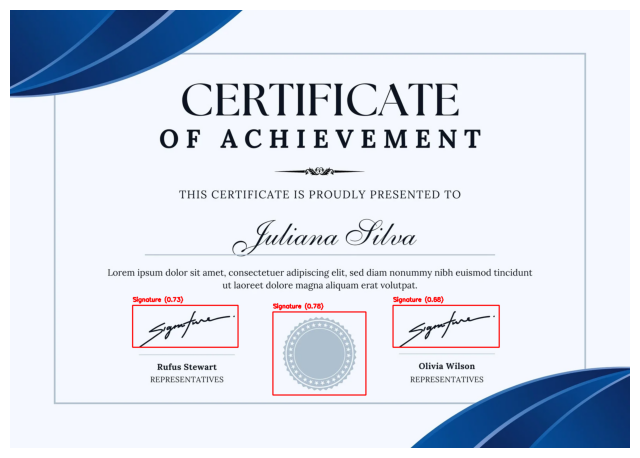


0: 448x1024 1 signature, 8.3ms
Speed: 3.7ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 1024)
Saved cropped signature: /kaggle/working/cropped/2_crop_0.png


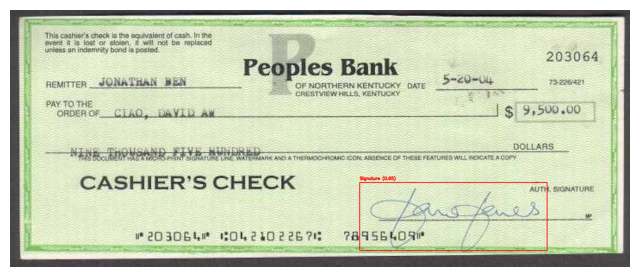

In [21]:
import cv2
import os
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

# Path to the folder containing signature images
image_folder = '/kaggle/input/test-image'
output_folder = '/kaggle/working/cropped/'  # Folder to save cropped signatures
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# List all image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.tif', '.webp'))]

# Loop through the images and process them
for image_file in image_files:
    # Load the image
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for visualization

    # Run inference on the image
    results = model(image_rgb)

    # Create a copy of the image for visualization
    image_with_boxes = image_rgb.copy()

    # Loop through each result
    for result in results:
        predicted_bboxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes in (x1, y1, x2, y2) format
        predicted_class_ids = result.boxes.cls.cpu().numpy()  # Class ids
        predicted_confidences = result.boxes.conf.cpu().numpy()  # Confidence scores

        for bbox_idx, (bbox, cls, conf) in enumerate(zip(predicted_bboxes, predicted_class_ids, predicted_confidences)):
            x1, y1, x2, y2 = map(int, bbox)  # Convert to integer pixel values

            # Draw bounding box on the image
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box with thickness 2
            label = f"Signature ({conf:.2f})"
            cv2.putText(image_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Crop the bounding box region from the original image
            cropped_signature = image[y1:y2, x1:x2]

            # Save the cropped image
            cropped_filename = f"{os.path.splitext(image_file)[0]}_crop_{bbox_idx}.png"
            cropped_path = os.path.join(output_folder, cropped_filename)
            cv2.imwrite(cropped_path, cropped_signature)
            print(f"Saved cropped signature: {cropped_path}")

    # Show the image with bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()


In [ ]:
import os
os.listdir('/kaggle/input')